# Metagenomic Classification - Shotgun Sequencing

This notebook trains a classification model on the shotgun sequencing dataset using a 3-mer stride 1 model following the Genomic-ULMFiT procedure. First the general bacterial genomic language model is fine tuned, then the fine tuned model is used to initialize the classification model.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.text import *
from Bio import Seq
from Bio.Seq import Seq
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
from Bio.SeqFeature import FeatureLocation, CompoundLocation
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score

In [3]:
sys.path.append("../../..")
from utils import *

In [4]:
path = Path('F:/genome/bacterial genomes/')

# Shotgun LM

In [5]:
classification_df = pd.read_csv(path/'s16_shotgun_sequences.csv')

In [6]:
classification_df.head()

,Sequence,Species,set
0,TTAATACTCTGCTACTGTGACGTTACTCGCAGAAGAAGCACCGGCT...,Gammaproteobacteria Alteromonadales Moritellac...,train
1,CTGCATGGCTGTCGCCAGCTCGTGTTGTGAAATGTTGGGTTAAGTC...,Gammaproteobacteria Alteromonadales Moritellac...,train
2,TACAATGGCGCATACAAAGGGCTGCAAACCAGCAATGGTAAGCGAA...,Gammaproteobacteria Alteromonadales Moritellac...,train
3,TGGGGAATATTGCACAATGGGGGAAACCCTGATGCAGCCATACCGC...,Gammaproteobacteria Alteromonadales Moritellac...,train
4,AAGCGGTGGAGCATGTGGTTTAATTCGATGCAACGCGAAGAACCTT...,Gammaproteobacteria Alteromonadales Moritellac...,train


In [7]:
train_df = classification_df[classification_df.set == 'train']
valid_df = classification_df[classification_df.set == 'valid']
test_df = classification_df[classification_df.set == 'test']

In [8]:
train_df.shape, valid_df.shape, test_df.shape

((23493, 3), (1771, 3), (1954, 3))

In [9]:
voc = np.load(path/'bact_vocab_3m1s.npy')
model_vocab = GenomicVocab(voc)

In [10]:
tok = Tokenizer(partial(GenomicTokenizer, ngram=3, stride=1), n_cpus=1, pre_rules=[], post_rules=[], special_cases=['xxpad'])

In [11]:
data = GenomicTextLMDataBunch.from_df(path, train_df, valid_df, bs=880, tokenizer=tok, 
                              chunksize=10000, text_cols='Sequence', label_cols='Species', vocab=model_vocab)

In [14]:
config = dict(emb_sz=400, n_hid=1150, n_layers=3, pad_token=0, qrnn=False, output_p=0.25, 
                          hidden_p=0.1, input_p=0.2, embed_p=0.02, weight_p=0.15, tie_weights=True, out_bias=True)
drop_mult = 0.4

In [15]:
learn = get_model_LM(data, drop_mult, config)

In [16]:
learn.load('b1_3m1s');

In [17]:
learn.model

SequentialRNN(
  (0): AWD_LSTM(
    (encoder): Embedding(65, 400, padding_idx=0)
    (encoder_dp): EmbeddingDropout(
      (emb): Embedding(65, 400, padding_idx=0)
    )
    (rnns): ModuleList(
      (0): WeightDropout(
        (module): LSTM(400, 1150, batch_first=True)
      )
      (1): WeightDropout(
        (module): LSTM(1150, 1150, batch_first=True)
      )
      (2): WeightDropout(
        (module): LSTM(1150, 400, batch_first=True)
      )
    )
    (input_dp): RNNDropout()
    (hidden_dps): ModuleList(
      (0): RNNDropout()
      (1): RNNDropout()
      (2): RNNDropout()
    )
  )
  (1): LinearDecoder(
    (decoder): Linear(in_features=400, out_features=65, bias=True)
    (output_dp): RNNDropout()
  )
)

In [18]:
learn = learn.to_fp16(dynamic=True);

In [20]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


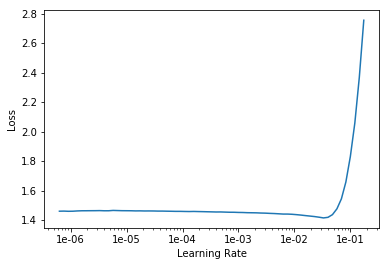

In [21]:
learn.recorder.plot()

# Training


In [22]:
learn.fit_one_cycle(10, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,1.242226,1.062576,0.540365,00:59
1,1.023581,0.934164,0.601386,01:00
2,0.925041,0.882771,0.627902,01:00
3,0.876196,0.851718,0.644485,01:00
4,0.832701,0.831466,0.660388,01:01
5,0.805884,0.809865,0.667541,01:01
6,0.782437,0.796673,0.675329,01:01
7,0.761841,0.788734,0.681301,01:01
8,0.745312,0.785414,0.684172,01:01
9,0.739241,0.786227,0.684119,01:01


In [23]:
learn.save('s16_sg_LM_3m1s')
learn.save_encoder('s16_sg_LM_3m1s_enc')

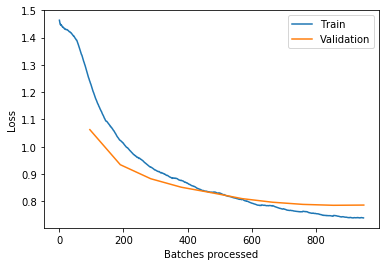

In [24]:
learn.recorder.plot_losses()

# Classification

In [5]:
classification_df = pd.read_csv(path/'s16_shotgun_sequences.csv')

In [6]:
classification_df.head()

,Sequence,Species,set
0,TTAATACTCTGCTACTGTGACGTTACTCGCAGAAGAAGCACCGGCT...,Gammaproteobacteria Alteromonadales Moritellac...,train
1,CTGCATGGCTGTCGCCAGCTCGTGTTGTGAAATGTTGGGTTAAGTC...,Gammaproteobacteria Alteromonadales Moritellac...,train
2,TACAATGGCGCATACAAAGGGCTGCAAACCAGCAATGGTAAGCGAA...,Gammaproteobacteria Alteromonadales Moritellac...,train
3,TGGGGAATATTGCACAATGGGGGAAACCCTGATGCAGCCATACCGC...,Gammaproteobacteria Alteromonadales Moritellac...,train
4,AAGCGGTGGAGCATGTGGTTTAATTCGATGCAACGCGAAGAACCTT...,Gammaproteobacteria Alteromonadales Moritellac...,train


In [7]:
train_df = classification_df[classification_df.set == 'train']
valid_df = classification_df[classification_df.set == 'valid']
test_df = classification_df[classification_df.set == 'test']

In [8]:
voc = np.load(path/'bact_vocab_3m1s.npy')
model_vocab = GenomicVocab(voc)

In [9]:
tok = Tokenizer(partial(GenomicTokenizer, ngram=3, stride=1), n_cpus=1, pre_rules=[], post_rules=[], special_cases=['xxpad'])
data_clas = GenomicTextClasDataBunch.from_df(path, train_df, valid_df,
                                             tokenizer=tok, vocab=model_vocab,
                                            text_cols='Sequence', label_cols='Species', bs=400)

In [12]:
clas_config = dict(emb_sz=400, n_hid=1150, n_layers=3, pad_token=0, qrnn=False, output_p=0.4, 
                       hidden_p=0.2, input_p=0.6, embed_p=0.1, weight_p=0.5)
drop_mult = 0.5

In [13]:
learn = get_model_clas(data_clas, drop_mult, clas_config)

In [14]:
learn.model

SequentialRNN(
  (0): MultiBatchEncoder(
    (module): AWD_LSTM(
      (encoder): Embedding(65, 400, padding_idx=0)
      (encoder_dp): EmbeddingDropout(
        (emb): Embedding(65, 400, padding_idx=0)
      )
      (rnns): ModuleList(
        (0): WeightDropout(
          (module): LSTM(400, 1150, batch_first=True)
        )
        (1): WeightDropout(
          (module): LSTM(1150, 1150, batch_first=True)
        )
        (2): WeightDropout(
          (module): LSTM(1150, 400, batch_first=True)
        )
      )
      (input_dp): RNNDropout()
      (hidden_dps): ModuleList(
        (0): RNNDropout()
        (1): RNNDropout()
        (2): RNNDropout()
      )
    )
  )
  (1): PoolingLinearClassifier(
    (layers): Sequential(
      (0): BatchNorm1d(1200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Dropout(p=0.2)
      (2): Linear(in_features=1200, out_features=50, bias=True)
      (3): ReLU(inplace)
      (4): BatchNorm1d(50, eps=1e-05, momentum=0.1, a

In [15]:
learn.load_encoder('s16_sg_LM_3m1s_enc')
learn.freeze()

In [16]:
learn = learn.to_fp16(dynamic=True);

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


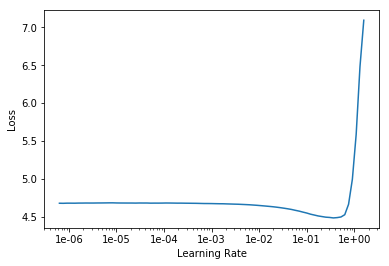

In [17]:
learn.lr_find()
learn.recorder.plot()

In [18]:
learn.fit_one_cycle(10, 5e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.250828,3.613787,0.121400,00:32
1,3.664455,2.778000,0.238283,00:32
2,3.369870,2.472136,0.285150,00:32
3,3.163075,2.193307,0.356861,00:32
4,3.034397,2.060876,0.404856,00:32
5,2.884784,1.932083,0.440994,00:32
6,2.764374,1.801995,0.463015,00:32
7,2.670841,1.708408,0.504800,00:32
8,2.557488,1.612143,0.526256,00:32
9,2.502507,1.611845,0.530209,00:32


In [19]:
learn.freeze_to(-2)
learn.fit_one_cycle(8, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,2.344203,1.461479,0.568041,00:38
1,2.005550,1.152183,0.622812,00:38
2,1.657911,0.910863,0.702993,00:39
3,1.362218,0.775891,0.747036,00:39
4,1.153971,0.660018,0.776398,00:39
5,1.003681,0.595673,0.798419,00:39
6,0.909652,0.569279,0.809147,00:39
7,0.856348,0.567139,0.813100,00:39


In [20]:
learn.freeze_to(-3)
learn.fit_one_cycle(8, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.809768,0.562133,0.808018,00:59
1,0.796906,0.539092,0.822134,00:59
2,0.781228,0.516347,0.825522,00:59
3,0.723313,0.482323,0.830604,00:59
4,0.670367,0.458075,0.839074,00:59
5,0.623668,0.442229,0.843591,00:59
6,0.583350,0.435240,0.844720,00:59
7,0.563357,0.432761,0.845850,00:59


In [21]:
learn.unfreeze()
learn.fit_one_cycle(8, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.546767,0.437289,0.843591,01:13
1,0.564084,0.440683,0.854320,01:13
2,0.573756,0.421194,0.857143,01:13
3,0.555468,0.398101,0.867307,01:13
4,0.510365,0.384599,0.873518,01:13
5,0.474414,0.378831,0.871824,01:13
6,0.450796,0.368379,0.869565,01:13
7,0.430233,0.368581,0.869565,01:13


In [22]:
learn.fit_one_cycle(12, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.426080,0.367227,0.868436,01:13
1,0.431139,0.364201,0.874082,01:12
2,0.430506,0.381092,0.875776,01:12
3,0.438474,0.384015,0.872388,01:13
4,0.431528,0.371588,0.875776,01:13
5,0.413828,0.370764,0.878035,01:13
6,0.390373,0.350846,0.884246,01:13
7,0.359448,0.344209,0.887634,01:13
8,0.340185,0.345482,0.888763,01:12
9,0.330215,0.344812,0.886505,01:12


In [23]:
learn.save('metagenomic_sg_genus_finetune_3m1s')

In [16]:
learn.load('metagenomic_sg_genus_finetune_3m1s_2');

In [24]:
data_clas = GenomicTextClasDataBunch.from_df(path, train_df, test_df, tokenizer=tok, vocab=model_vocab,
                                            text_cols='Sequence', label_cols='Species', bs=400)
learn.data = data_clas

In [25]:
preds = learn.get_preds()

In [26]:
p = torch.argmax(preds[0], dim=1)

In [27]:
precision_score(preds[1], p, average='macro')

0.8824603540520275

In [28]:
recall_score(preds[1], p, average='macro')

0.876957352062245

In [29]:
accuracy_score(preds[1], p)

0.8797338792221086

In [30]:
f1_score(preds[1], p, average='macro')

0.8758983735588179

In [31]:
pred_df = pd.DataFrame(preds[1], columns=['gt_int'])

In [32]:
pred_df['gt_name'] = pred_df.gt_int.map(lambda x: data_clas.classes[x])

In [33]:
pred_df['predicted_int'] = p
pred_df['predicted_name'] = pred_df.predicted_int.map(lambda x: data_clas.classes[x])

In [34]:
pred_df.gt_name = pred_df.gt_name.map(lambda x: ' '.join(x.split('_', 1)) if len(x.split()) == 3 else x)

In [35]:
pred_df.predicted_name = pred_df.predicted_name.map(lambda x: ' '.join(x.split('_', 1)) if len(x.split()) == 3 else x)

In [36]:
taxa_list = ['Class', 'Order', 'Family', 'Genus']
for i, taxa in enumerate(taxa_list):
    print(taxa)
    print((pred_df.gt_name.map(lambda x: x.split()[i]) == pred_df.predicted_name.map(lambda x: x.split()[i])).mean())
    print('\n')

Class
0.9994882292732856


Order
0.9872057318321392


Family
0.9723643807574207


Genus
0.8797338792221086


